In [ ]:
!pip install pywavelets torchinfo matplotlib seaborn --quiet

import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import GroupShuffleSplit
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AD_all_patients.csv')
print(f"Dataset shape: {df.shape}")
display(df.head())
print("Columns:", list(df.columns))


Dataset shape: (848640, 17)


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,status
0,116.99375,41.09375,66.69375,-64.50625,-126.40625,8.39375,22.49375,42.19375,53.29375,4.49375,2.49375,73.79375,129.29375,0.09375,-124.90625,-245.50625,1
1,115.93125,38.63125,64.73125,-64.66875,-125.26875,8.73125,27.03125,43.23125,57.53125,11.13125,2.33125,72.23125,125.73125,-5.46875,-123.06875,-248.76875,1
2,115.72500,38.32500,66.02500,-62.67500,-135.37500,9.02500,29.42500,47.12500,49.92500,24.42500,1.22500,72.92500,123.22500,-3.07500,-129.97500,-246.27500,1
3,120.15625,40.75625,71.05625,-59.54375,-148.34375,12.15625,32.25625,49.05625,41.05625,12.75625,1.85625,73.55625,128.65625,-0.14375,-133.24375,-242.04375,1
4,119.50000,39.50000,71.30000,-59.20000,-125.50000,14.80000,28.50000,48.80000,42.20000,-1.20000,1.40000,70.30000,116.10000,3.40000,-129.00000,-240.90000,1


Columns: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'status']


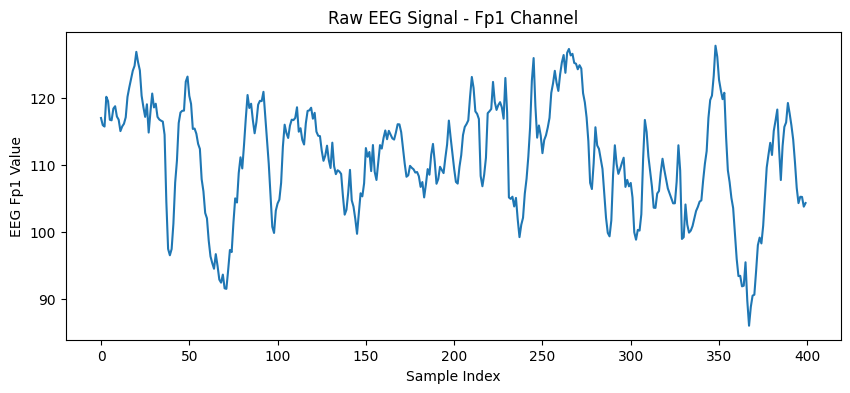

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['Fp1'][:400])
plt.xlabel('Sample Index')
plt.ylabel('EEG Fp1 Value')
plt.title('Raw EEG Signal - Fp1 Channel')
plt.show()


In [ ]:
EEG_channels = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
    'T3', 'C3', 'Cz', 'C4', 'T4',
    'T5', 'P3', 'Pz', 'P4'
]
label_col = 'status'

df = df.drop_duplicates()
chunk_size = 5000
df = df.reset_index(drop=True)
df['group'] = df.index // chunk_size

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df['group']
train_idx, test_idx = next(gss.split(df, df[label_col], groups=groups))
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

X_train, y_train = train_df[EEG_channels].values, train_df[label_col].values
X_test, y_test = test_df[EEG_channels].values, test_df[label_col].values

print("Train label distribution:")
print(pd.Series(y_train).value_counts())
print("Test label distribution:")
print(pd.Series(y_test).value_counts())

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("Label classes:", le.classes_)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)


Train label distribution:
1    414786
0    262818
Name: count, dtype: int64
Test label distribution:
1    96434
0    73566
Name: count, dtype: int64
Label classes: [0 1]


LWT transformed feature shape: (677604, 16)


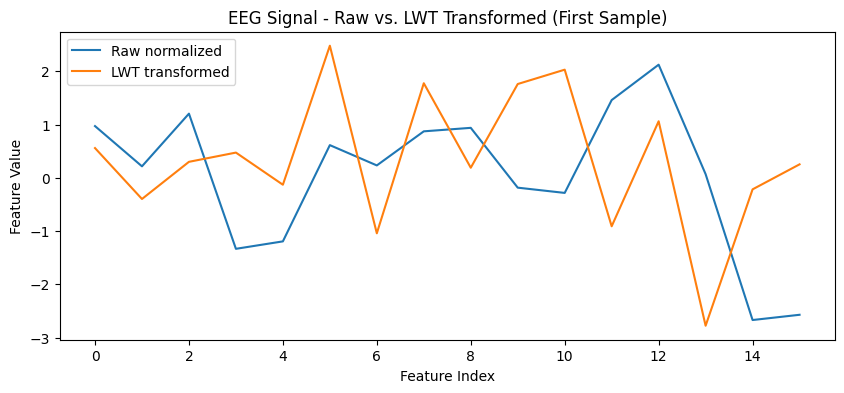

In [ ]:
def lwt_row(x):
    coeffs = x
    for _ in range(3):
        ca, cd = pywt.dwt(coeffs, 'haar')
        coeffs = np.concatenate([ca, cd])
    return coeffs

X_train_lwt = np.array([lwt_row(row) for row in X_train_norm])
X_test_lwt = np.array([lwt_row(row) for row in X_test_norm])

print("LWT transformed feature shape:", X_train_lwt.shape)

# Plot raw vs LWT features of the first sample
plt.figure(figsize=(10, 4))
plt.plot(X_train_norm[0], label='Raw normalized')
plt.plot(X_train_lwt[0], label='LWT transformed')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('EEG Signal - Raw vs. LWT Transformed (First Sample)')
plt.legend()
plt.show()


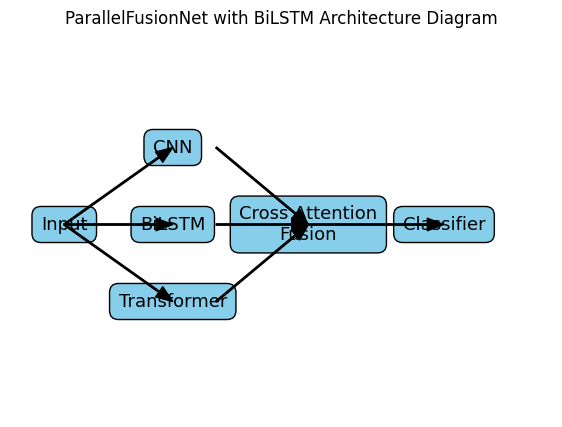

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.axis('off')
blocks = {
    'Input': (0.1, 0.5),
    'CNN': (0.3, 0.7),
    'BiLSTM': (0.3, 0.5),
    'Transformer': (0.3, 0.3),
    'Cross Attention\nFusion': (0.55, 0.5),
    'Classifier': (0.8, 0.5)
}
for name, (x, y) in blocks.items():
    ax.text(x, y, name, ha='center', va='center', fontsize=13, bbox=dict(facecolor='skyblue', edgecolor='black', boxstyle='round,pad=0.5'))
arrowprops = dict(facecolor='black', width=1, headwidth=9)
ax.annotate('', xy=blocks['CNN'], xytext=blocks['Input'], arrowprops=arrowprops)
ax.annotate('', xy=blocks['BiLSTM'], xytext=blocks['Input'], arrowprops=arrowprops)
ax.annotate('', xy=blocks['Transformer'], xytext=blocks['Input'], arrowprops=arrowprops)
ax.annotate('', xy=blocks['Cross Attention\nFusion'], xytext=(0.38, 0.7), arrowprops=arrowprops)
ax.annotate('', xy=blocks['Cross Attention\nFusion'], xytext=(0.38, 0.5), arrowprops=arrowprops)
ax.annotate('', xy=blocks['Cross Attention\nFusion'], xytext=(0.38, 0.3), arrowprops=arrowprops)
ax.annotate('', xy=blocks['Classifier'], xytext=blocks['Cross Attention\nFusion'], arrowprops=arrowprops)
plt.title("ParallelFusionNet with BiLSTM Architecture Diagram")
plt.show()


In [ ]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class CrossAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.2):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x, context):
        b, t, d = x.shape
        h = self.heads
        q = self.to_q(x).view(b, t, h, d // h).transpose(1, 2)
        k = self.to_k(context).view(b, t, h, d // h).transpose(1, 2)
        v = self.to_v(context).view(b, t, h, d // h).transpose(1, 2)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = torch.softmax(attn, dim=-1)
        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(b, t, d)
        return self.to_out(out)

class ParallelFusionNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        cnn_dim = 128
        lstm_dim = 128
        trans_dim = 128
        self.cnn = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, cnn_dim),
            nn.ReLU()
        )
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_dim, num_layers=2,
                              batch_first=True, bidirectional=True, dropout=0.5)
        self.lstm_fc = nn.Linear(lstm_dim * 2, lstm_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=trans_dim, nhead=8, dropout=0.5, batch_first=True)
        self.transformer = nn.Sequential(
            nn.Linear(input_dim, trans_dim),
            encoder_layer,
        )
        self.cross_attn1 = CrossAttention(dim=cnn_dim, heads=8)
        self.cross_attn2 = CrossAttention(dim=lstm_dim, heads=8)
        self.cls = nn.Sequential(
            nn.Linear(cnn_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        b = x.size(0)
        cnn_feat = self.cnn(x)
        lstm_in = x.unsqueeze(1)
        bilstm_out, _ = self.bilstm(lstm_in)  # BiLSTM used here
        bilstm_feat = self.lstm_fc(bilstm_out[:, -1])
        trans_in = x.unsqueeze(1)
        trans_feat = self.transformer(trans_in)[:, -1]
        cnn_feat_x = cnn_feat.unsqueeze(1)
        bilstm_feat_x = bilstm_feat.unsqueeze(1)
        trans_feat_x = trans_feat.unsqueeze(1)
        attn_1 = self.cross_attn1(cnn_feat_x, bilstm_feat_x).squeeze(1)
        attn_2 = self.cross_attn2(bilstm_feat_x, trans_feat_x).squeeze(1)
        fusion = attn_1 + attn_2
        return self.cls(fusion)



=== Evaluation Metrics ===
          Accuracy: 98.06
         Precision: 98.07
Recall/Sensitivity: 98.06
       Specificity: 98.54
          F1-Score: 98.06
               MCC: 96.06
               FPR: 1.46
               FNR: 2.30
               NPV: 97.03
               FDR: 1.13
[Epoch 1/5] Train Loss: 0.0248 | Val Acc: 98.06%

=== Evaluation Metrics ===
          Accuracy: 98.22
         Precision: 98.24
Recall/Sensitivity: 98.22
       Specificity: 99.13
          F1-Score: 98.22
               MCC: 96.40
               FPR: 0.87
               FNR: 2.47
               NPV: 96.83
               FDR: 0.68
[Epoch 2/5] Train Loss: 0.0044 | Val Acc: 98.22%

=== Evaluation Metrics ===
          Accuracy: 98.40
         Precision: 98.42
Recall/Sensitivity: 98.40
       Specificity: 99.33
          F1-Score: 98.40
               MCC: 96.77
               FPR: 0.67
               FNR: 2.31
               NPV: 97.04
               FDR: 0.52
[Epoch 3/5] Train Loss: 0.0032 | Val Acc: 98.40

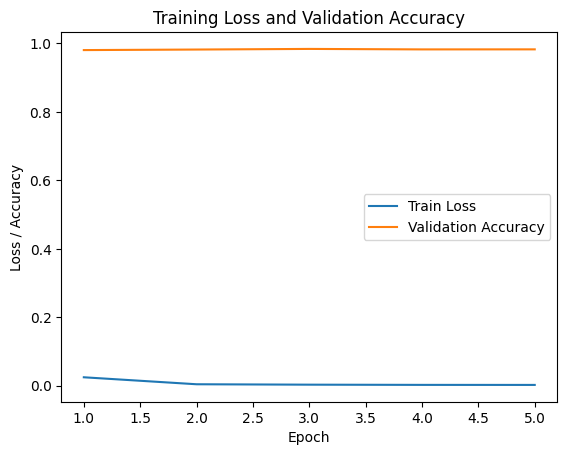

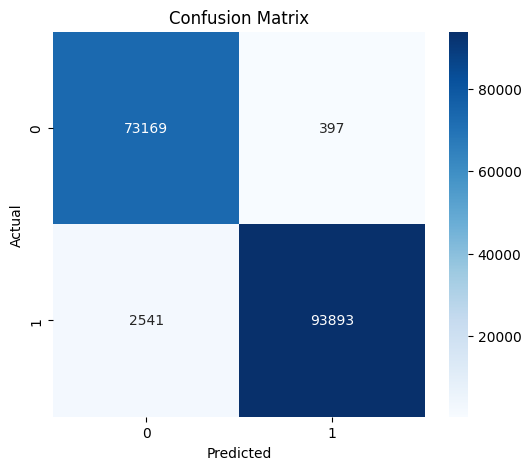

In [ ]:
batch_size = 64
train_loader = DataLoader(EEGDataset(X_train_lwt, y_train_enc), batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(EEGDataset(X_test_lwt, y_test_enc), batch_size=batch_size, shuffle=False, drop_last=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParallelFusionNet(input_dim=X_train_lwt.shape[1], num_classes=len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)

def advanced_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) else 0
        fpr = fp / (fp + tn) if (fp + tn) else 0
        fnr = fn / (tp + fn) if (tp + fn) else 0
        npv = tn / (tn + fn) if (tn + fn) else 0
        fdr = fp / (fp + tp) if (fp + tp) else 0
    else:
        specificity = fpr = fnr = npv = fdr = 0
    return {
        'Accuracy': acc * 100,
        'Precision': precision * 100,
        'Recall/Sensitivity': recall * 100,
        'Specificity': specificity * 100,
        'F1-Score': f1 * 100,
        'MCC': mcc * 100,
        'FPR': fpr * 100,
        'FNR': fnr * 100,
        'NPV': npv * 100,
        'FDR': fdr * 100
    }

def train_epoch(loader):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            probs = model(xb)
            preds.append(probs.argmax(dim=1).cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    metrics = advanced_metrics(trues, preds)
    print("\n=== Evaluation Metrics ===")
    for k, v in metrics.items():
        print(f"{k:>18}: {v:.2f}")
    print("=" * 30)
    return metrics['Accuracy'] / 100, metrics, preds, trues

epochs = 5
train_losses = []
val_accs = []
for epoch in range(epochs):
    train_loss = train_epoch(train_loader)
    val_acc, val_metrics, test_preds, test_trues = evaluate(test_loader)
    train_losses.append(train_loss)
    val_accs.append(val_acc)
    print(f"[Epoch {epoch + 1}/{epochs}] Train Loss: {train_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")

# Plot Training Loss and Validation Accuracy
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(test_trues, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
summary(model, input_size=(batch_size, X_train_lwt.shape[1]))


Layer (type:depth-idx)                   Output Shape              Param #
ParallelFusionNet                        [64, 2]                   --
├─Sequential: 1-1                        [64, 128]                 --
│    └─Linear: 2-1                       [64, 256]                 4,352
│    └─ReLU: 2-2                         [64, 256]                 --
│    └─Dropout: 2-3                      [64, 256]                 --
│    └─Linear: 2-4                       [64, 128]                 32,896
│    └─ReLU: 2-5                         [64, 128]                 --
├─LSTM: 1-2                              [64, 1, 256]              544,768
├─Linear: 1-3                            [64, 128]                 32,896
├─Sequential: 1-4                        [64, 1, 128]              --
│    └─Linear: 2-6                       [64, 1, 128]              2,176
│    └─TransformerEncoderLayer: 2-7      [64, 1, 128]              --
│    │    └─MultiheadAttention: 3-1      [64, 1, 128]             

In [ ]:
# Assuming model is trained and test_loader is defined

# Function to decode encoded labels to original classes
def decode_labels(encoded_labels, label_encoder):
    return label_encoder.inverse_transform(encoded_labels)

# Get a batch from test_loader
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = outputs.argmax(dim=1).cpu().numpy()
        trues = yb.numpy()
        break  # take only first batch for demonstration

# Decode labels to original string labels
predicted_labels = decode_labels(preds, le)
true_labels = decode_labels(trues, le)

# Display predictions vs actual for first batch
print("Predicted labels:", predicted_labels)
print("Actual labels   :", true_labels)

# Optional: Show sample-wise comparison in dataframe
comparison_df = pd.DataFrame({"Predicted": predicted_labels, "Actual": true_labels})
display(comparison_df.head(10))  # show first 10 samples only


Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual labels   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,Predicted,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


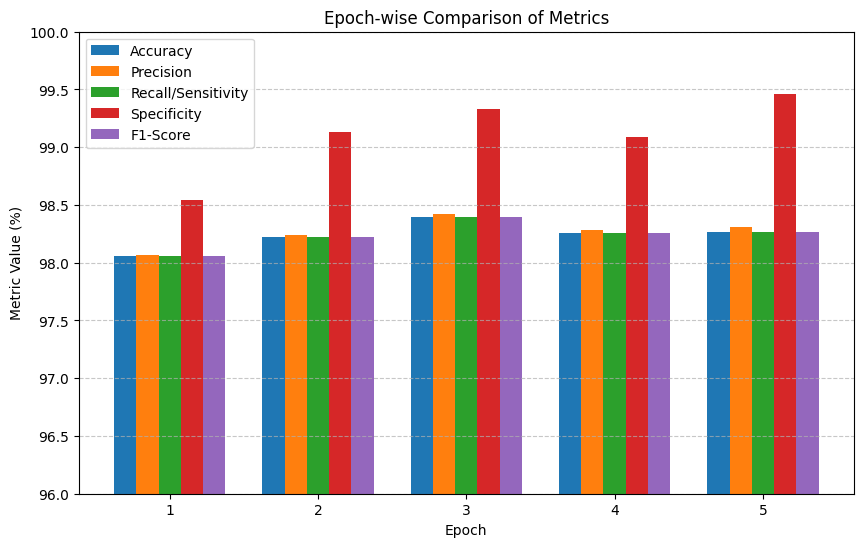

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Metric values per epoch
metrics_data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Accuracy': [98.06, 98.22, 98.40, 98.26, 98.27],
    'Precision': [98.07, 98.24, 98.42, 98.28, 98.31],
    'Recall/Sensitivity': [98.06, 98.22, 98.40, 98.26, 98.27],
    'Specificity': [98.54, 99.13, 99.33, 99.09, 99.46],
    'F1-Score': [98.06, 98.22, 98.40, 98.26, 98.27]
}

df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
plt.bar(df_metrics['Epoch'] - 0.3, df_metrics['Accuracy'], width=0.15, label='Accuracy')
plt.bar(df_metrics['Epoch'] - 0.15, df_metrics['Precision'], width=0.15, label='Precision')
plt.bar(df_metrics['Epoch'], df_metrics['Recall/Sensitivity'], width=0.15, label='Recall/Sensitivity')
plt.bar(df_metrics['Epoch'] + 0.15, df_metrics['Specificity'], width=0.15, label='Specificity')
plt.bar(df_metrics['Epoch'] + 0.3, df_metrics['F1-Score'], width=0.15, label='F1-Score')

plt.ylim(96, 100)
plt.yticks(np.arange(96, 100.5, 0.5))  # Decimal ticks at intervals of 0.5
plt.xlabel('Epoch')
plt.ylabel('Metric Value (%)')
plt.title('Epoch-wise Comparison of Metrics')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
